In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent.parent
sys.path.append(str(parent_dir))

# Import necessary modules
from src.train import run_model_new
from src.utils_plot import plot_loss_and_all_solution, plot_head_loss
from src.load_save import save_model

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [4]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Sun Mar  3 14:32:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8              N/A / ERR! |   1974MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
num_heads = 12
equation_name = "duffing"

np.random.seed(42)
# generate the training stiffness parameter alpha
alpha_bounds = (5, 20)
def generate_alpha(k, alpha_bounds = alpha_bounds):
  alpha_list = np.zeros(k)
  for i in range(k):
    alpha_list[i] = np.random.uniform(alpha_bounds[0], alpha_bounds[1])
  return alpha_list
alpha_list = generate_alpha(num_heads)
#alpha_list = [2, 3, 4, 5, 6]

# create the A matrix associated with the ODE
def get_A(alpha):
    return torch.tensor([[0., -1.], [0.1, alpha]], device=dev).double() 
A_list = [get_A(i)for i in alpha_list]

# training IC (random or not)
def random_IC(x_bound=[1, 3], y_bound=[0, 2]):
    ICx = np.random.uniform(x_bound[0], x_bound[1], 1)
    ICy = np.random.uniform(y_bound[0], y_bound[1], 1)
    return torch.tensor([ICx, ICy], device=dev)
#IC_list = [random_IC() for i in range(num_heads)]
IC_list = [torch.tensor([[1.], [0.5]], device=dev).double() for _ in range(num_heads)]

force_list = [
    lambda t: torch.cat([torch.zeros(len(t), device=dev).unsqueeze(1), torch.cos(t).unsqueeze(1)], dim=1).double()
    if not isinstance(t, (float, int))
    else np.array([0, np.cos(t)]).T
    for _ in range(num_heads)
]

In [6]:
x_range = [0, 10]
activation = "silu"
hid_lay = list(np.array([128, 128, 256, 512]))
hid_lay = list(np.array([128, 128, 132]))
num_equations = 2
iterations = 20000


# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def double_coupled_equation(t, y, A, force):
    return np.array([force(t)[0].detach().item() - A[0][1] * y[1] - A[0][0] * y[0],
                     force(t)[1].detach().item() - A[1][0] * y[0] - A[1][1] * y[1]])

numerical_sol_fct = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="Radau").y)

#numerical_sol_fct = None

In [7]:
sample_size = 200
lr = 1e-4
decay = True
verbose = True

# run model which has two non-coupled equations
loss_hist, trained_model, model_time = run_model_new(iterations=iterations, x_range=x_range, lr=lr,
                                                     A_list=A_list, IC_list=IC_list, force=force_list,
                                                     hid_lay=hid_lay, activation=activation,
                                                     num_equations=num_equations, num_heads=num_heads,
                                                     sample_size = sample_size, decay=decay, dev=dev,
                                                     verbose=verbose, true_functs=None, save=False)

# date tag to save
from datetime import datetime
now = datetime.now()
# Format the date and time as a string in the format 'mmddhhmm'
formatted_datetime = now.strftime('%m%d%H%M')
# Convert the formatted string to an integer
formatted_datetime_int = int(formatted_datetime)

  0%|          | 0/20000 [00:00<?, ?it/s]

Iterations 0, L_total = 1.7013930634426462, L_ODE = 0.9611206959308822, L_IC = 0.740272367511764
Iterations 100, L_total = 0.509380784039591, L_ODE = 0.22186703299614438, L_IC = 0.28751375104344656
Iterations 200, L_total = 0.23722941554547006, L_ODE = 0.16921815048023273, L_IC = 0.06801126506523733
Iterations 300, L_total = 0.19495059190901562, L_ODE = 0.14287248471428032, L_IC = 0.052078107194735296
Iterations 400, L_total = 0.18508508017585534, L_ODE = 0.1346722089018319, L_IC = 0.05041287127402344
Iterations 500, L_total = 0.1686542099813733, L_ODE = 0.11917380901365832, L_IC = 0.04948040096771498
Iterations 600, L_total = 0.14891323087233233, L_ODE = 0.10229959709258282, L_IC = 0.04661363377974949
Iterations 700, L_total = 0.14053756941803497, L_ODE = 0.09169870156369492, L_IC = 0.04883886785434006
Iterations 800, L_total = 0.12619677241428962, L_ODE = 0.07551789685789677, L_IC = 0.05067887555639284
Iterations 900, L_total = 0.12102244651988713, L_ODE = 0.06976235276086563, L_IC =

In [8]:
# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def double_coupled_equation(t, y, A, force):
    return np.array([force(t)[0] - A[0][1] * y[1] - A[0][0] * y[0],
                     force(t)[1] - A[1][0] * y[0] - A[1][1] * y[1]])

numerical_sol_fct = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="Radau").y)

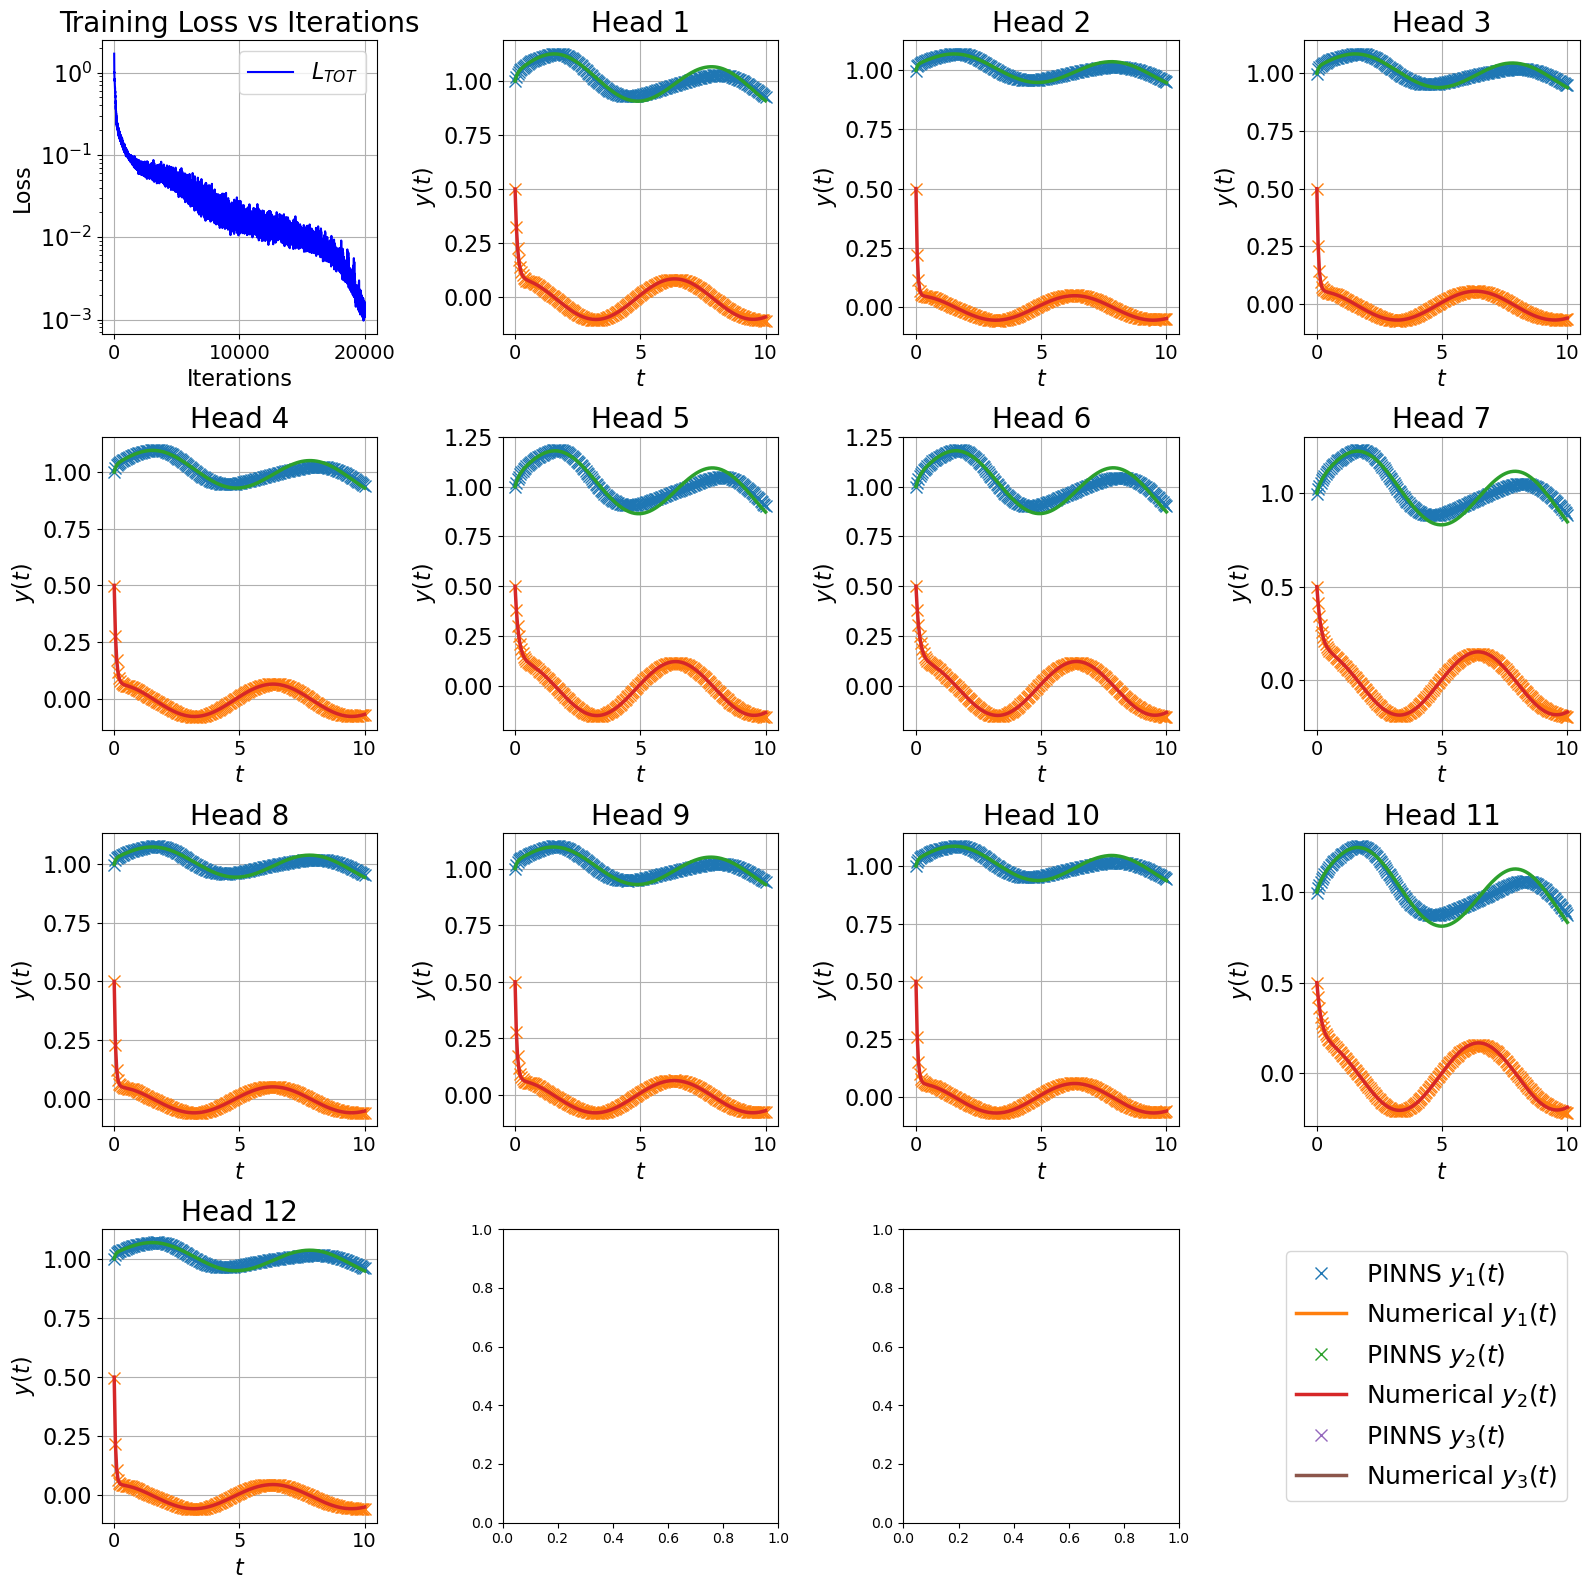

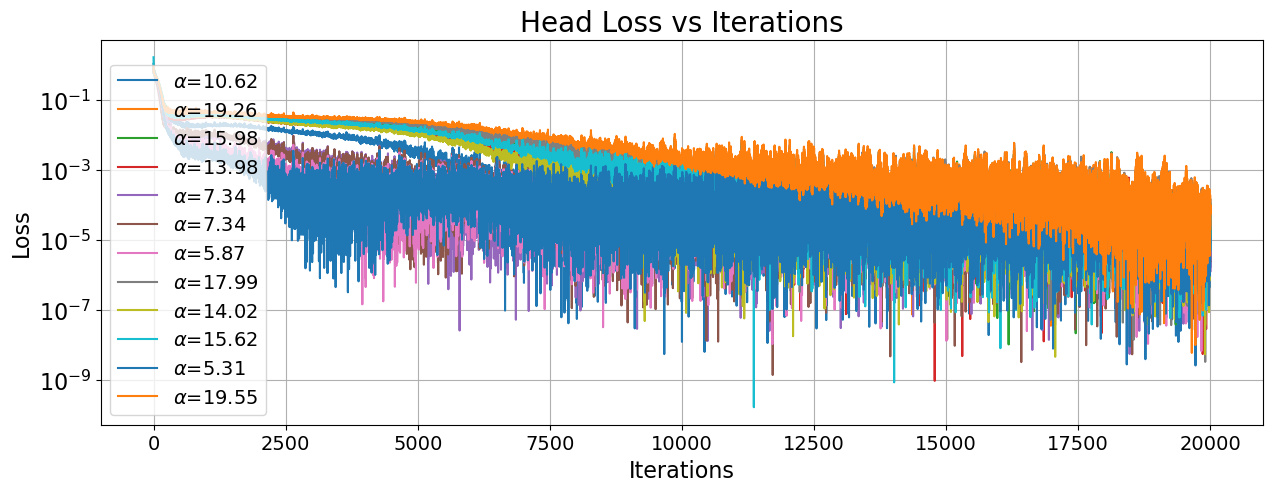

In [9]:
plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_fct,
                           trained_model=trained_model, IC_list=IC_list, A_list=A_list,
                           force=force_list, train_losses=loss_hist, device=dev)
plot_head_loss(loss_hist["head"], alpha_list)

In [10]:
model_name = "base_model_2"
save_model(trained_model, formatted_datetime_int, equation_name, model_name,
           x_range, iterations, hid_lay, num_equations, num_heads, A_list,
           IC_list, force_list, alpha_list, loss_hist)

D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\model_history/duffing/history_base_model_2_3031525.json


# Train on the non linear function

In [4]:
from src.train import run_model_non_linear

In [5]:
num_heads = 1
equation_name = "duffing"

np.random.seed(42)
# generate the training stiffness parameter alpha
alpha_bounds = (1, 5)
def generate_alpha(k, alpha_bounds = alpha_bounds):
  alpha_list = np.zeros(k)
  for i in range(k):
    alpha_list[i] = np.random.uniform(alpha_bounds[0], alpha_bounds[1])
  return alpha_list
alpha_list = generate_alpha(num_heads)
alpha_list = [10]
beta = 0.5

def equation(t, y, alpha, beta=beta):
    if isinstance(y, torch.Tensor):
      yp = torch.zeros_like(y)
      force = torch.cos(t)
    elif isinstance(y, np.ndarray):
      yp = np.zeros_like(y)
      force = np.cos(t)
    yp[..., 0] = y[..., 1]
    yp[..., 1] = -0.1*y[..., 0] - alpha*y[..., 1] - beta*y[..., 0]**3 + force
    return yp

equation_list = [lambda t, y, Alpha=alpha: equation(t, y, Alpha) for alpha in alpha_list]

# training IC (random or not)
def random_IC(x_bound=[1.5, 2.5], y_bound=[0, 0]):
    ICx = np.random.uniform(x_bound[0], x_bound[1], 1)
    ICy = np.random.uniform(y_bound[0], y_bound[1], 1)
    return torch.tensor([ICx, ICy], device=dev)
#IC_list = [random_IC() for i in range(num_heads)]
IC_list = [torch.tensor([[1.], [0.5]], device=dev).double() for _ in range(num_heads)]

In [6]:
numerical_sol_fct = lambda x, v, alpha, beta: (solve_ivp(equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(alpha, beta), t_eval=x.squeeze(), method="Radau").y.T)
numerical_sol_list = [lambda x, IC=ic.detach().cpu().numpy(), Alpha=alpha, beta=beta: numerical_sol_fct(x, IC, Alpha, beta) for ic, alpha in zip(IC_list, alpha_list)]

In [7]:
x_range = [0, 5]
activation = "silu"
hid_lay = list(np.array([128, 128, 256, 512]))
reparametrization=True
num_equations = 2
iterations = 100

In [8]:
sample_size = 200
lr = 1e-4
decay = True
verbose = True

# run model which has two non-coupled equations
loss_hist, trained_model, model_time = run_model_non_linear(iterations=iterations, x_range=x_range, lr=lr,
                                                            equation_list=equation_list, IC_list=IC_list,
                                                            hid_lay=hid_lay, activation=activation,
                                                            num_equations=num_equations, num_heads=num_heads,
                                                            sample_size = sample_size, decay=decay, dev=dev, verbose=verbose,
                                                            true_functs=None, reparametrization=reparametrization)

# date tag to save
from datetime import datetime
now = datetime.now()
# Format the date and time as a string in the format 'mmddhhmm'
formatted_datetime = now.strftime('%m%d%H%M')
# Convert the formatted string to an integer
formatted_datetime_int = int(formatted_datetime)

  0%|          | 0/100 [00:00<?, ?it/s]

Iterations 0, L_total = 1.130867124890393, L_ODE = 1.130867124890393, L_IC = 0.0
Model Training Complete in 22.645 seconds


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

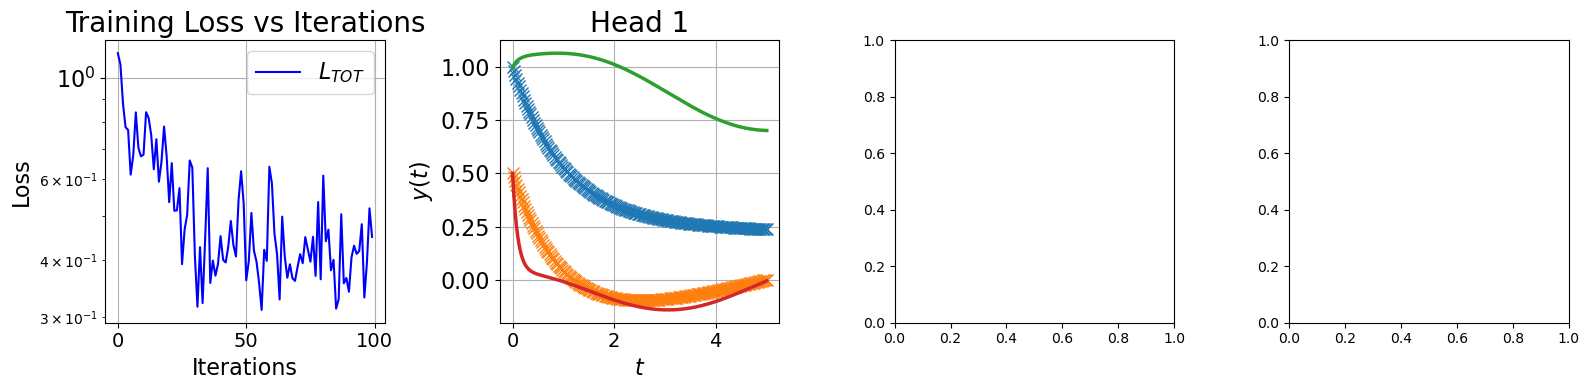

In [9]:
plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_list,
                           trained_model=trained_model, IC_list=IC_list,
                           A_list=None, force=None, train_losses=loss_hist,
                           device=dev, equation_list=equation_list, reparametrization=reparametrization)

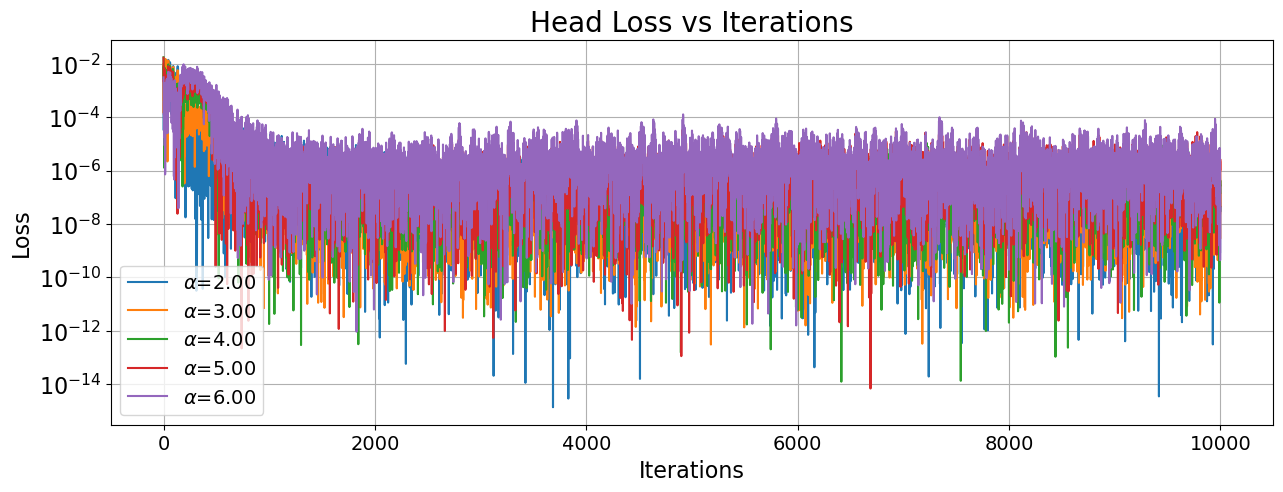

In [16]:
plot_head_loss(loss_hist["head"], alpha_list)

In [17]:
model_name = "nonlinear_repara"
A_list=[torch.tensor([np.nan])]
force_list = [torch.tensor([np.nan])]
save_model(trained_model, formatted_datetime_int, equation_name, model_name,
           x_range, iterations, hid_lay, num_equations, num_heads, A_list,
           IC_list, force_list, alpha_list, loss_hist)

D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\model_history/duffing/history_nonlinear_repara_2141608.json


# increase stiffness

In [11]:
from tqdm.auto import trange

num_heads = 1
alpha_list = [10, 20, 30, 40]

lr_list = [0.0001, 0.00008, 0.00004, 0.00001]
iterations_list = [20000, 30000, 40000, 50000]
solution_PINNS = []

rng = np.random.default_rng()
t_eval = torch.arange(x_range[0], x_range[1], 0.001, requires_grad=True, device=dev).double()
t_eval = t_eval[np.concatenate(([0], rng.choice(range(1, len(t_eval)), size=512 - 1, replace=False)))]
t_eval = t_eval.reshape(-1, 1)
t_eval, _ = t_eval.sort(dim=0)

for i in trange(len(alpha_list)):
    equation_transfer = lambda t, y, Alpha=alpha_list[i]: equation(t, y, Alpha)
    _, model_transfer, _ = run_model_non_linear(iterations=iterations_list[i], x_range=x_range, lr=lr_list[i],
                                                equation_list=[equation_transfer], IC_list=[IC_list[0]],
                                                hid_lay=hid_lay, activation=activation,
                                                num_equations=num_equations, num_heads=num_heads,
                                                sample_size = sample_size, decay=decay, dev=dev, verbose=verbose,
                                                true_functs=None, reparametrization=reparametrization)
    solution_PINNS.append(model_transfer(t_eval, reparametrization=reparametrization)[0])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

Iterations 0, L_total = 0.9934577304928718, L_ODE = 0.9934577304928718, L_IC = 0.0
Iterations 100, L_total = 0.4141843601061102, L_ODE = 0.4141843601061102, L_IC = 0.0
Iterations 200, L_total = 0.27929941580801504, L_ODE = 0.27929941580801504, L_IC = 0.0
Iterations 300, L_total = 0.11936322087496395, L_ODE = 0.11936322087496395, L_IC = 0.0
Iterations 400, L_total = 0.06316903132701276, L_ODE = 0.06316903132701276, L_IC = 0.0
Iterations 500, L_total = 0.06261405423030465, L_ODE = 0.06261405423030465, L_IC = 0.0
Iterations 600, L_total = 0.050180228904549685, L_ODE = 0.050180228904549685, L_IC = 0.0
Iterations 700, L_total = 0.036721438601750596, L_ODE = 0.036721438601750596, L_IC = 9.860761315262648e-32
Iterations 800, L_total = 0.02069997925930598, L_ODE = 0.02069997925930598, L_IC = 0.0
Iterations 900, L_total = 0.013303919457674984, L_ODE = 0.013303919457674984, L_IC = 0.0
Iterations 1000, L_total = 0.022083361331868535, L_ODE = 0.022083361331868535, L_IC = 0.0
Iterations 1100, L_tot

  0%|          | 0/30000 [00:00<?, ?it/s]

Iterations 0, L_total = 4.074124331245569, L_ODE = 4.074124331245569, L_IC = 0.0
Iterations 100, L_total = 1.6143368441878139, L_ODE = 1.6143368441878139, L_IC = 1.5407439555097887e-33
Iterations 200, L_total = 1.1851923546107817, L_ODE = 1.1851923546107817, L_IC = 0.0
Iterations 300, L_total = 0.40264328014177253, L_ODE = 0.40264328014177253, L_IC = 0.0
Iterations 400, L_total = 0.687700644714033, L_ODE = 0.687700644714033, L_IC = 0.0
Iterations 500, L_total = 0.7116222415539535, L_ODE = 0.7116222415539535, L_IC = 0.0
Iterations 600, L_total = 0.48364988448208474, L_ODE = 0.48364988448208474, L_IC = 0.0
Iterations 700, L_total = 0.6886163113736449, L_ODE = 0.6886163113736449, L_IC = 0.0
Iterations 800, L_total = 0.211212712076351, L_ODE = 0.211212712076351, L_IC = 0.0
Iterations 900, L_total = 0.4186217465504044, L_ODE = 0.4186217465504044, L_IC = 0.0
Iterations 1000, L_total = 0.19292251889320747, L_ODE = 0.19292251889320747, L_IC = 0.0
Iterations 1100, L_total = 0.1916643695982684, 

  0%|          | 0/40000 [00:00<?, ?it/s]

Iterations 0, L_total = 16.52662641496954, L_ODE = 16.52662641496954, L_IC = 0.0
Iterations 100, L_total = 4.994052291594586, L_ODE = 4.994052291594586, L_IC = 0.0
Iterations 200, L_total = 4.946710180303665, L_ODE = 4.946710180303665, L_IC = 0.0
Iterations 300, L_total = 4.111214569955665, L_ODE = 4.111214569955665, L_IC = 0.0
Iterations 400, L_total = 2.8600473180783634, L_ODE = 2.8600473180783634, L_IC = 6.162975822039155e-33
Iterations 500, L_total = 2.67849786866175, L_ODE = 2.67849786866175, L_IC = 0.0
Iterations 600, L_total = 2.3993228183190007, L_ODE = 2.3993228183190007, L_IC = 0.0
Iterations 700, L_total = 2.6966626833742455, L_ODE = 2.6966626833742455, L_IC = 0.0
Iterations 800, L_total = 3.2752668489649546, L_ODE = 3.2752668489649546, L_IC = 2.465190328815662e-32
Iterations 900, L_total = 1.290120325605727, L_ODE = 1.290120325605727, L_IC = 0.0
Iterations 1000, L_total = 1.7821015788559504, L_ODE = 1.7821015788559504, L_IC = 0.0
Iterations 1100, L_total = 1.738756288409483

  0%|          | 0/50000 [00:00<?, ?it/s]

Iterations 0, L_total = 15.350546580541717, L_ODE = 15.350546580541717, L_IC = 0.0
Iterations 100, L_total = 12.621709407478729, L_ODE = 12.621709407478729, L_IC = 1.5407439555097887e-33
Iterations 200, L_total = 9.260171618343916, L_ODE = 9.260171618343916, L_IC = 6.162975822039155e-33
Iterations 300, L_total = 13.647427973037352, L_ODE = 13.647427973037352, L_IC = 6.162975822039155e-33
Iterations 400, L_total = 8.354465637826136, L_ODE = 8.354465637826136, L_IC = 7.703719777548943e-33
Iterations 500, L_total = 9.285699513329146, L_ODE = 9.285699513329146, L_IC = 1.5407439555097887e-33
Iterations 600, L_total = 9.367148159123044, L_ODE = 9.367148159123044, L_IC = 0.0
Iterations 700, L_total = 6.151595296161775, L_ODE = 6.151595296161775, L_IC = 0.0
Iterations 800, L_total = 10.719419735551606, L_ODE = 10.719419735551606, L_IC = 6.162975822039155e-33
Iterations 900, L_total = 5.642610804945674, L_ODE = 5.642610804945674, L_IC = 0.0
Iterations 1000, L_total = 6.650574450360605, L_ODE = 

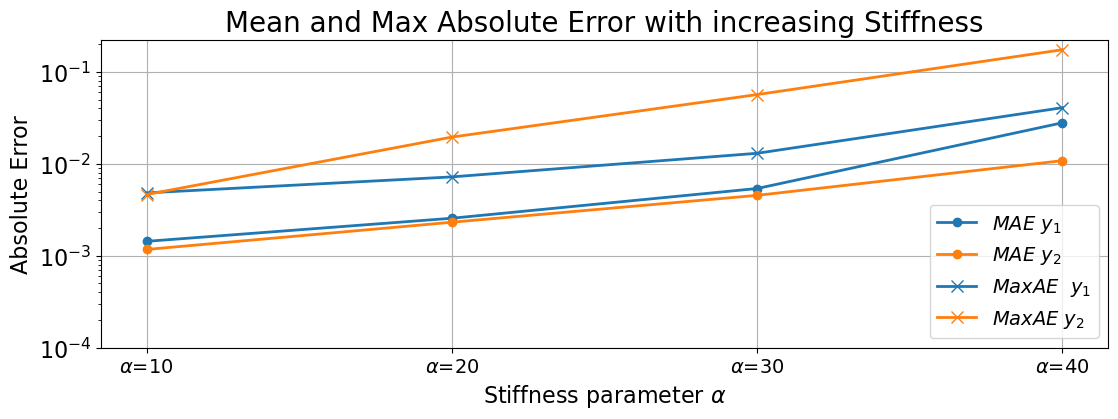

In [13]:
mae_y1 = []
mae_y2 = []
maxae_y1 = []
maxae_y2 = []

for i in range(len(alpha_list)):
    true_funct = lambda x: numerical_sol_fct(x, v=IC_list[0].detach().cpu().numpy(), alpha=alpha_list[i], beta=beta)
    pinns = solution_PINNS[i].detach().cpu().numpy()
    numerical = true_funct(t_eval.detach().cpu().numpy())
    absolute_error = np.abs(pinns[:, 0, :] - numerical)
    mae_y1.append(absolute_error.mean(0)[0])
    mae_y2.append(absolute_error.mean(0)[1])
    maxae_y1.append(absolute_error.max(0)[0])
    maxae_y2.append(absolute_error.max(0)[1])

fig, ax = plt.subplots(1, figsize=(13, 4))

ax.plot(alpha_list, mae_y1, "-o", label="$MAE$ ${y_1}$", linewidth=2, markersize=6)
ax.plot(alpha_list, mae_y2,"-o", label="$MAE$ ${y_2}$", linewidth=2, markersize=6)
ax.plot(alpha_list, maxae_y1, "-x", color="#1f77b4", label="$MaxAE$  ${y_1}$", linewidth=2, markersize=8)
ax.plot(alpha_list, maxae_y2, "-x", color="#ff7f0e", label="$MaxAE$ ${y_2}$", linewidth=2, markersize=8)

ax.set_yscale("log")
ax.set_title(r"Mean and Max Absolute Error with increasing Stiffness", fontsize=20)
ax.set_xlabel(r'Stiffness parameter $\alpha$', fontsize=16)
ax.set_ylabel('Absolute Error', fontsize=16)
ax.set_xticks(alpha_list, [rf"$\alpha$={i}" for i in alpha_list])
ax.set_yticks([0.1, 0.01, 0.001, 0.0001],
              [r"$10^{-1}$", r"$10^{-2}$", r"$10^{-3}$", r"$10^{-4}$"])
ax.grid()
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=16)
ax.legend(loc='best', fontsize=14)

In [14]:
# import json

# history = {}
# history["alpha_list"] = alpha_list
# history["mae_y1"] = mae_y1
# history["mae_y2"] = mae_y2
# history["maxae_y1"] = maxae_y1
# history["maxae_y2"] = maxae_y2

# with open(r"D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\result_history\Duffing_Error_Trained.json",  "w") as fp:
#     json.dump(history, fp)